In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_lambdas_autoencoder, train_lambdas_cov
from src.evaluation.evaluate import Evaluation
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *

# Process Data

## 1. Load preprocessed images and tabular data
Several preprocessing steps were conducted on the raw images and tabular data - see notebook "data_preprocessing". 

In [2]:
images = np.load("../data/images/cleaned_images.npy")
tracks = np.load("../data/tracks/filtered_tracks.npy")
labels = np.load("../data/labels/filtered_y_train.npy")

print("Images shape: ", images.shape, "Tracks shape: ", tracks.shape, "Labels shape: ", labels.shape)

Images shape:  (1385, 1080, 2, 20, 20) Tracks shape:  (1385, 1080, 19) Labels shape:  (1385,)


## 2. Prepare for model training

### 1. FRET ratio calculation

In [3]:
fret_images = images[:,:,0,:,:] / images[:,:,1,:,:] 
fret_images = np.nan_to_num(fret_images, nan=0.0)

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_6262/3830351353.py:1: RuntimeWarning: invalid value encountered in divide
  fret_images = images[:,:,0,:,:] / images[:,:,1,:,:]


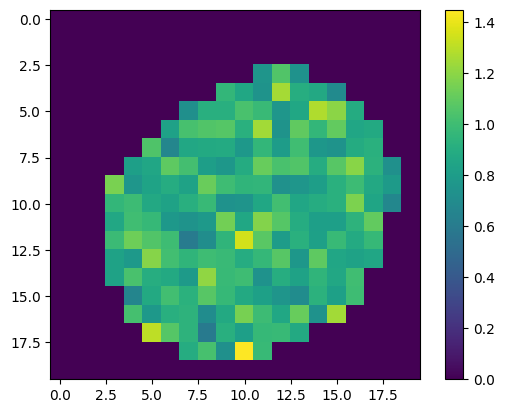

In [4]:
plt.imshow(fret_images[0,1000,:,:])
plt.colorbar()

### 2. Normalise images frame-wise

In [5]:
norm_images = normalize_images_per_frame(fret_images)

### 3. Center cells

In [6]:
centered_images = center_cells(norm_images)

### 4. Train-test split

In [7]:
train_indexes, test_indexes = train_test_split(
        np.arange(len(labels)),
        test_size=0.2,
        stratify=labels,
        random_state=42
    )
    
train_images = centered_images[train_indexes]
train_labels = labels[train_indexes]
train_tracks = tracks[train_indexes]
test_images = centered_images[test_indexes]
test_labels = labels[test_indexes]
test_tracks = tracks[test_indexes]

In [8]:
np.save("../data/images/train_images.npy", train_images)
np.save("../data/images/test_images.npy", test_images)
np.save("../data/labels/train_labels.npy", train_labels)
np.save("../data/labels/test_labels.npy", test_labels)
np.save("../data/tracks/train_tracks.npy", train_tracks)
np.save("../data/tracks/test_tracks.npy", test_tracks)

### 5. Data Augmentation

In [2]:
train_images = np.load("../data/images/train_images.npy")
test_images = np.load("../data/images/test_images.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

In [3]:
train_images_augmented, train_labels_augmented = augment_dataset(train_images, train_labels, augmentations)

In [4]:
train_images_augmented.shape, train_labels_augmented.shape

((2184, 1080, 20, 20), (2184,))

In [ ]:
# np.save("../data/images/train_images_augmented.npy", train_images_augmented)
# np.save("../data/labels/train_labels_augmented.npy", train_labels_augmented)

In [ ]:
## FOR VISUALISATION PURPOSES ONLY ## - augment test set
test_images_augmented, test_labels_augmented = augment_dataset(test_images, test_labels, augmentations)

### 6. Stretch image intensities in a frame-wise way
This is done to do a scaling of the intensities in each cell, so that the minimum value is 0 (but keeping the same "relationship" between pixel values)

In [13]:
def stretch_intensities_global(train_images, test_images, epsilon=0.001):
    """
    Stretch the intensities of train_images and test_images globally using the same min and max.
    
    Args:
        train_images (ndarray): Training image data
        test_images (ndarray): Testing image data
        epsilon (float): Value to prevent division by zero

    Returns:
        scaled_train_images (ndarray): Scaled training images
        scaled_test_images (ndarray): Scaled testing images
    """
    # Combine the datasets to compute global min and max
    cells, frames, height, width = train_images.shape
    
    scaled_train_images = np.empty(train_images.shape)
    scaled_test_images = np.empty(test_images.shape)

    for i in range(frames):
        combined_images = np.concatenate([train_images[:, i][train_images[:, i] > 0], test_images[:, i][test_images[:, i] > 0]])
        global_min = np.min(combined_images)
        global_max = np.max(combined_images)

        if global_max > global_min:

            scaled_train_images[:,i] = (train_images[:,i] - global_min) / (global_max - global_min)
            scaled_train_images[:,i] = scaled_train_images[:,i] * (1 - epsilon) + epsilon
            scaled_train_images[:,i][train_images[:,i] == 0] = 0  # Preserve zero values (background)

            scaled_test_images[:,i] = (test_images[:,i] - global_min) / (global_max - global_min)
            scaled_test_images[:,i] = scaled_test_images[:,i] * (1 - epsilon) + epsilon
            scaled_test_images[:,i][test_images[:,i] == 0] = 0  # Preserve zero values (background)

        else:
            # If global_max == global_min, leave unchanged
            scaled_train_images[:,i] = train_images[:,i]
            scaled_test_images[:,i] = test_images[:,i]

    return scaled_train_images, scaled_test_images


In [14]:
stretched_x_train, stretched_x_test = stretch_intensities_global(train_images_augmented, test_images)

In [17]:
np.save("../data/images/train_images_augmented_stretched.npy", stretched_x_train)
np.save("../data/images/test_images_augmented_stretched.npy", stretched_x_test)

print("Augmented images shape: ", stretched_x_train.shape, "Augmented labels shape: ", train_labels_augmented.shape, "Test images shape: ", stretched_x_test.shape, "Test labels shape: ", test_labels.shape, "Train tracks shape: ", train_tracks.shape, "Test tracks shape: ", test_tracks.shape)

Augmented images shape:  (2184, 1080, 20, 20) Augmented labels shape:  (2184,) Test images shape:  (277, 1080, 20, 20) Test labels shape:  (277,) Train tracks shape:  (1108, 1080, 19) Test tracks shape:  (277, 1080, 19)


In [18]:
train_labels.shape

(1108,)

# Model Workflow - Training and Evaluation

## Tabular Data

### Simple MLP (No hidden layers)

### Complex MLP 

#### Temporal study

## Image Data

### Full CellFate Workflow 

#### 1. Train Adversarial Autoencoder (AAE)

#### 2. Train AAE with Contrastive loss and Covariance loss

#### 3. Classify with MLP 

#### 4. Evaluation 

#### 5. Temporal study

#### 6. Latent Space dimensionality study

### Only Adversarial Autoencoder

#### 1. Train Adversarial Autoencoder
With the same number of epochs and hyperparameters as before

#### 2. Evaluation 

### ImageNet classification